## Data pipeline for predicting length of stay in ER.

## Imports and Globals

In [1]:
import os
import random
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cyclops.feature_handler import FeatureHandler
from cyclops.plotter import plot_timeline, set_bars_color, setup_plot
from cyclops.processor import run_data_pipeline
from cyclops.processors.aggregate import Aggregator
from cyclops.processors.column_names import (
    ADMIT_TIMESTAMP,
    AGE,
    DIAGNOSIS_CODE,
    DISCHARGE_DISPOSITION,
    DISCHARGE_TIMESTAMP,
    ENCOUNTER_ID,
    EVENT_CATEGORY,
    EVENT_NAME,
    EVENT_TIMESTAMP,
    EVENT_VALUE,
    HOSPITAL_ID,
    LENGTH_OF_STAY_IN_ER,
    RESTRICT_TIMESTAMP,
    SEX,
    TIMESTEP,
    TRIAGE_LEVEL,
    WINDOW_START_TIMESTAMP,
)
from cyclops.processors.constants import SMH
from cyclops.processors.events import (
    combine_events,
    convert_to_events,
    normalize_events,
)
from cyclops.processors.impute import Imputer
from cyclops.processors.statics import compute_statics
from cyclops.processors.string_ops import replace_if_string_match, to_lower
from cyclops.processors.util import (
    create_indicator_variables,
    fill_missing_timesteps,
    gather_columns,
    pivot_aggregated_events_to_features,
)
from cyclops.query import gemini
from cyclops.utils.file import load_dataframe, save_dataframe

LOS = "los"
BASE_DATA_PATH = "/mnt/nfs/project/delirium/drift_exp/los_er"
AGGREGATION_WINDOW = 24
AGGREGATION_BUCKET_SIZE = 1

2022-06-28 16:34:12,001 INFO cyclops.orm     - Database setup, ready to run queries!


## Run query, save

In [ ]:
os.makedirs(BASE_DATA_PATH, exist_ok=True)
er_admin_table = gemini.get_table(gemini.ER_ADMIN)

years = [2015, 2016, 2018, 2019, 2020]
encounters = gemini.patient_encounters(
    er_admin_table=er_admin_table,
    years=years,
)
encounters_labs = gemini.events(
    patient_encounters_table=encounters.query, event_category="lab"
)
imaging = gemini.imaging(years=years)
transfusions = gemini.blood_transfusions(years=years)
interventions = gemini.interventions(years=years)

encounters.run()
print(f"{len(encounters.data)} rows extracted!")

encounters_labs.run()
print(f"{len(encounters_labs.data)} rows extracted!")
encounters_labs.save(os.path.join(BASE_DATA_PATH, "labs"))
encounters_labs.clear_data()

imaging.run()
print(f"{len(imaging.data)} rows extracted!")
transfusions.run()
print(f"{len(transfusions.data)} rows extracted!")
interventions.run()
print(f"{len(interventions.data)} rows extracted!")

encounters_imaging = pd.merge(
    encounters.data, imaging.data, on=ENCOUNTER_ID, how="inner"
)
encounters_transfusions = pd.merge(
    encounters.data, transfusions.data, on=ENCOUNTER_ID, how="inner"
)
encounters_interventions = pd.merge(
    encounters.data, interventions.data, on=ENCOUNTER_ID, how="inner"
)

encounters.save(os.path.join(BASE_DATA_PATH, "admin_er"))
encounters_imaging.to_parquet(os.path.join(BASE_DATA_PATH, "imaging.parquet"))
encounters_transfusions.to_parquet(os.path.join(BASE_DATA_PATH, "transfusions.parquet"))
encounters_interventions.to_parquet(
    os.path.join(BASE_DATA_PATH, "interventions.parquet")
)

## Read saved query data

In [2]:
encounters_data = pd.read_parquet(os.path.join(BASE_DATA_PATH, "admin_er.parquet"))
labs_data = pd.read_parquet(os.path.join(BASE_DATA_PATH, "labs.parquet"))
imaging_data = pd.read_parquet(os.path.join(BASE_DATA_PATH, "imaging.parquet"))
transfusions_data = pd.read_parquet(
    os.path.join(BASE_DATA_PATH, "transfusions.parquet")
)
interventions_data = pd.read_parquet(
    os.path.join(BASE_DATA_PATH, "interventions.parquet")
)
labs_data[EVENT_CATEGORY] = "labs"

## Map triage level

In [3]:
def remap(triage_level):
    map_ = {
        "1": "RESUSCITATION",
        "2": "EMERGENCY",
        "3": "URGENT",
        "4": "SEMI-URGENT",
        "5": "NON-URGENT",
    }
    return map_.get(triage_level, "UNKNOWN")


encounters_data[TRIAGE_LEVEL] = encounters_data[TRIAGE_LEVEL].apply(remap)

## Map imaging and transfusions such that they can be treated as events

In [4]:
imaging_data = imaging_data.rename(
    columns={
        "imaging_test_description": EVENT_NAME,
        "performed_date_time": EVENT_TIMESTAMP,
    }
)
imaging_data[EVENT_CATEGORY] = "imaging"
imaging_data[EVENT_VALUE] = 1

transfusions_data = transfusions_data.rename(
    columns={"issue_date_time": EVENT_TIMESTAMP}
)
transfusions_data[EVENT_NAME] = transfusions_data["rbc_mapped"]
transfusions_data[EVENT_NAME] = transfusions_data[EVENT_NAME].apply(
    lambda x: "rbc" if x else "non-rbc"
)
transfusions_data[EVENT_VALUE] = 1
transfusions_data[EVENT_CATEGORY] = "transfusions"

##  Process interventions such that they can be treated as events

In [5]:
interventions_data[EVENT_VALUE] = 1
interventions_data[EVENT_CATEGORY] = "interventions"

binary_mapped_cols = [
    "endoscopy_mapped",
    "gi_endoscopy_mapped",
    "bronch_endoscopy_mapped",
    "dialysis_mapped",
    "inv_mech_vent_mapped",
    "surgery_mapped",
]
interventions_data["intervention_episode_start_time"].loc[
    interventions_data["intervention_episode_start_time"].isna()
] = "12:00:00"
interventions_data[EVENT_TIMESTAMP] = pd.to_datetime(
    interventions_data["intervention_episode_start_date"].astype(str)
    + " "
    + interventions_data["intervention_episode_start_time"].astype(str)
)
interventions_data[EVENT_TIMESTAMP] = interventions_data[EVENT_TIMESTAMP].astype(
    "datetime64[ns]"
)
interventions_data["unmapped_intervention"] = ~(
    interventions_data["endoscopy_mapped"]
    | interventions_data["gi_endoscopy_mapped"]
    | interventions_data["bronch_endoscopy_mapped"]
    | interventions_data["dialysis_mapped"]
    | interventions_data["inv_mech_vent_mapped"]
    | interventions_data["surgery_mapped"]
)
interventions_data[EVENT_NAME] = interventions_data[
    binary_mapped_cols + ["unmapped_intervention"]
].idxmax(axis=1)

/tmp/ipykernel_546024/3783487325.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interventions_data["intervention_episode_start_time"].loc[


## Filter out encounters that had less than 1 hour LOS in ER

In [6]:
encounters_data_atleast_los_1_hrs = encounters_data.loc[
    ~encounters_data[LENGTH_OF_STAY_IN_ER].isna()
]
encounters_data_atleast_los_1_hrs = encounters_data_atleast_los_1_hrs.loc[
    encounters_data_atleast_los_1_hrs[LENGTH_OF_STAY_IN_ER] >= 1
]

## Filter out encounters that greater than 50 hours LOS in ER

In [7]:
encounters_data_atleast_los_1_hrs_within_timeframe = (
    encounters_data_atleast_los_1_hrs.loc[
        encounters_data_atleast_los_1_hrs[LENGTH_OF_STAY_IN_ER] <= 50
    ]
)
print(
    len(encounters_data_atleast_los_1_hrs_within_timeframe),
    len(encounters_data_atleast_los_1_hrs),
)

147708 154450


## Create smaller subset for train/val/test, plot LOS distribution

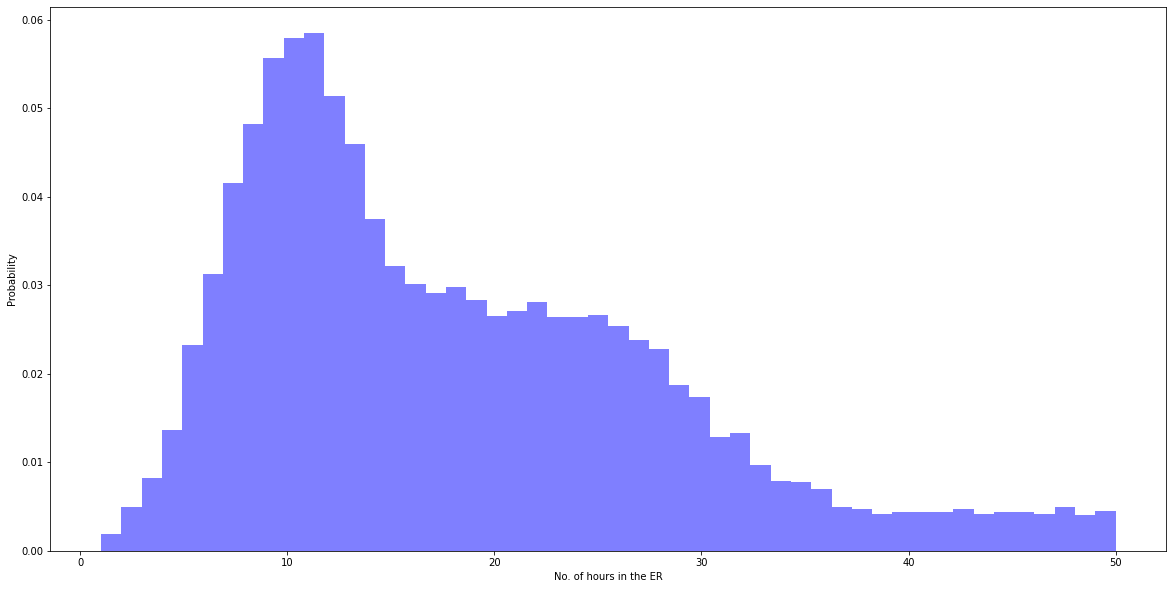

In [18]:
encounters_data_train_val_test = (
    encounters_data_atleast_los_1_hrs_within_timeframe.sample(20000)
)

data = np.array(list(encounters_data_train_val_test[LENGTH_OF_STAY_IN_ER]))

fig, ax = plt.subplots(figsize=(20, 10))
n, bins, patches = plt.hist(data, 50, facecolor="blue", alpha=0.5, density=True)
plt.xlabel("No. of hours in the ER")
plt.ylabel("Probability")
plt.show()

## Create ER discharge events

In [8]:
er_disch_events = convert_to_events(
    encounters_data_atleast_los_1_hrs,
    event_name="er_discharge",
    event_category="general",
    timestamp_col="er_discharge_timestamp",
)
er_disch_events[EVENT_VALUE] = 1
# er_disch_events

## Get admission/discharge events

In [9]:
admit_events = convert_to_events(
    encounters_data_atleast_los_1_hrs,
    event_name="admission",
    event_category="general",
    timestamp_col=ADMIT_TIMESTAMP,
)
disch_events = convert_to_events(
    encounters_data_atleast_los_1_hrs,
    event_name="discharge",
    event_category="general",
    timestamp_col=DISCHARGE_TIMESTAMP,
)

## Filter events to be in train_val_test subset

In [11]:
labs_train_val_test = labs_data.loc[
    labs_data[ENCOUNTER_ID].isin(encounters_data_train_val_test[ENCOUNTER_ID])
]
imaging_train_val_test = imaging_data.loc[
    imaging_data[ENCOUNTER_ID].isin(encounters_data_train_val_test[ENCOUNTER_ID])
]
transfusions_train_val_test = transfusions_data.loc[
    transfusions_data[ENCOUNTER_ID].isin(encounters_data_train_val_test[ENCOUNTER_ID])
]
interventions_train_val_test = interventions_data.loc[
    interventions_data[ENCOUNTER_ID].isin(encounters_data_train_val_test[ENCOUNTER_ID])
]
admit_events = admit_events.loc[
    admit_events[ENCOUNTER_ID].isin(encounters_data_train_val_test[ENCOUNTER_ID])
]
disch_events = disch_events.loc[
    disch_events[ENCOUNTER_ID].isin(encounters_data_train_val_test[ENCOUNTER_ID])
]
er_disch_events = er_disch_events.loc[
    er_disch_events[ENCOUNTER_ID].isin(encounters_data_train_val_test[ENCOUNTER_ID])
]

## Normalize all event data (names, string operations)

In [12]:
imaging_events = normalize_events(imaging_train_val_test)
transfusion_events = normalize_events(transfusions_train_val_test)
lab_events = normalize_events(labs_train_val_test)
er_disch_events = normalize_events(er_disch_events)
intervention_events = normalize_events(interventions_train_val_test)
admit_events = normalize_events(admit_events)
disch_events = normalize_events(disch_events)

2022-06-28 16:37:43,500 INFO cyclops.processors.util - Cleaning raw event data...
2022-06-28 16:37:43,504 INFO cyclops.processors.util - # samples: 79551, # encounters: 18685
2022-06-28 16:37:43,505 INFO cyclops.processors.util - # columns: 60, # encounters: 18685
2022-06-28 16:37:43,763 INFO cyclops.processors.util - Remove text in parentheses and normalize event names...
2022-06-28 16:37:43,766 INFO cyclops.processors.util - # samples: 79551, # encounters: 18685
2022-06-28 16:37:43,767 INFO cyclops.processors.util - # columns: 60, # encounters: 18685
2022-06-28 16:37:43,946 INFO cyclops.processors.util - Drop unsupported events...
2022-06-28 16:37:43,949 INFO cyclops.processors.util - # samples: 79551, # encounters: 18685
2022-06-28 16:37:43,951 INFO cyclops.processors.util - # columns: 60, # encounters: 18685
2022-06-28 16:37:44,018 INFO cyclops.processors.util - Normalize event categories...
2022-06-28 16:37:44,021 INFO cyclops.processors.util - # samples: 79551, # encounters: 1868

## Combine different event data, save

In [13]:
combined_events = combine_events(
    [
        intervention_events,
        imaging_events,
        transfusion_events,
        lab_events,
        er_disch_events,
        admit_events,
        disch_events,
    ]
)
save_dataframe(combined_events, os.path.join(BASE_DATA_PATH, "combined_events"))

2022-06-28 16:39:32,157 INFO cyclops.utils.file - Saving dataframe to /mnt/nfs/project/delirium/drift_exp/los_er/combined_events.parquet


'/mnt/nfs/project/delirium/drift_exp/los_er/combined_events.parquet'

## Load combined events

In [ ]:
combined_events = load_dataframe(os.path.join(BASE_DATA_PATH, "combined_events"))

## Aggregate combined events, save

In [ ]:
aggregator = Aggregator(bucket_size=AGGREGATION_BUCKET_SIZE, window=AGGREGATION_WINDOW)
aggregated_events = aggregator(combined_events)
save_dataframe(aggregated_events, os.path.join(BASE_DATA_PATH, "aggregated_events"))
save_dataframe(
    aggregator.meta["timestep_start_timestamp"],
    os.path.join(BASE_DATA_PATH, "aggmeta_start_ts"),
)
save_dataframe(
    aggregator.meta["timestep_end_timestamp"],
    os.path.join(BASE_DATA_PATH, "aggmeta_end_ts"),
)

2022-06-28 16:47:22,680 INFO cyclops.processors.util - Restricting events within window...
2022-06-28 16:47:22,689 INFO cyclops.processors.util - # samples: 780055, # encounters: 20000
2022-06-28 16:47:22,691 INFO cyclops.processors.util - # columns: 85, # encounters: 20000
2022-06-28 16:47:22,692 INFO cyclops.processors.util - Aggregating event features...
2022-06-28 16:47:22,700 INFO cyclops.processors.util - # samples: 780055, # encounters: 20000
2022-06-28 16:47:22,701 INFO cyclops.processors.util - # columns: 85, # encounters: 20000


## Load aggregated events, meta

In [ ]:
aggregated_events = load_dataframe(os.path.join(BASE_DATA_PATH, "aggregated_events"))
timestep_start_timestamps = load_dataframe(
    os.path.join(BASE_DATA_PATH, "aggmeta_start_ts")
)
timestep_end_timestamps = load_dataframe(os.path.join(BASE_DATA_PATH, "aggmeta_end_ts"))

## Some small number of events are getting aggregated to a 7th timestep!! (Debug later, remove for now)

In [ ]:
aggregated_events.loc[aggregated_events["timestep"] == 6]["event_name"].value_counts()

In [ ]:
aggregated_events = aggregated_events.loc[aggregated_events["timestep"] != 6]

## Pivot aggregated events to get column-wise temporal features and save it

In [ ]:
temporal_features = pivot_aggregated_events_to_features(aggregated_events, np.mean)
save_dataframe(temporal_features, os.path.join(BASE_DATA_PATH, "temporal_features"))

## Add to feature handler, with indicator variables.

In [ ]:
feature_handler = FeatureHandler()

temporal_features = load_dataframe(os.path.join(BASE_DATA_PATH, "temporal_features"))
feature_handler.add_features(temporal_features)
feature_handler.drop_features(["death"])

already_indicators = [
    "ct",
    "dialysis_mapped",
    "echo",
    "endoscopy_mapped",
    "interventional",
    "inv_mech_vent_mapped",
    "mri",
    "non-rbc",
    "other",
    "rbc",
    "surgery_mapped",
    "ultrasound",
    "unmapped_intervention",
    "x-ray",
]

temporal_features = feature_handler.features["temporal"]
indicators = create_indicator_variables(
    temporal_features[
        [col for col in temporal_features if col not in already_indicators]
    ]
)
feature_handler.add_features(indicators)
feature_handler.features["temporal"].columns

## Compute static features, save it

In [ ]:
encounters_train_val_test_static_cols = gather_columns(
    encounters_train_val_test,
    [
        ENCOUNTER_ID,
        AGE,
        SEX,
        HOSPITAL_ID,
        ADMIT_TIMESTAMP,
        DISCHARGE_TIMESTAMP,
        TRIAGE_LEVEL,
    ],
)
static_features = compute_statics(encounters_train_val_test_static_cols)
save_dataframe(static_features, os.path.join(BASE_DATA_PATH, "static_features"))

##  Load static features, add to feature handler, save all features

In [ ]:
static_features = load_dataframe(os.path.join(BASE_DATA_PATH, "static_features"))
feature_handler.add_features(
    static_features, reference_cols=[HOSPITAL_ID, ADMIT_TIMESTAMP, DISCHARGE_TIMESTAMP]
)
feature_handler.save(BASE_DATA_PATH, "features")

## Create new feature handler, load saved features from file

In [ ]:
feature_handler1 = FeatureHandler()
feature_handler1.load(BASE_DATA_PATH, "features")

In [ ]:
len(feature_handler1.features["temporal"].columns), len(
    feature_handler1.features["static"].columns
)

## Impute temporal features

In [ ]:
static = feature_handler1.features["static"]
temporal = feature_handler1.features["temporal"]

numerical_cols = feature_handler1.get_numerical_feature_names()["temporal"]
cat_cols = feature_handler1.get_categorical_feature_names()["temporal"]

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(temporal.isna().sum(axis=0))
# numerical_cols, cat_cols


# Remove encounters based on missingness.
# print(temporal.shape)
# encounter_ids = set(temporal.index.get_level_values(0))
# for encounter_id in encounter_ids:
#     features_encounter = temporal.loc[encounter_id]
#     not_indicators = [col_name for col_name in temporal.columns if 'indicator' not in col_name]
#     num_na_features = features_encounter[not_indicators].isna().sum().sum()
#     fraction_missing = num_na_features / (
#         len(features_encounter) * len(temporal.columns)
#     )
#     if fraction_missing > 0.4:
#         temporal = temporal.drop(encounter_id, level=ENCOUNTER_ID)
# num_encounters_dropped = len(encounter_ids) - len(
#     set(temporal.index.get_level_values(0))
# )
# print(num_encounters_dropped)

# mean over features (incomplete)
# imputer(temporal[numerical_cols]).fillna(temporal[numerical_cols].mean(level=0, numeric_only=True, skipna=True))

# Forward-fill, then backward
temporal[numerical_cols] = temporal[numerical_cols].ffill().bfill()

# Check no more missingness!
assert not temporal.isna().sum().sum() and not static.isna().sum().sum()

## Add static features to temporal, (duplicate for each timestep)

In [ ]:
# Train model with both static and temporal features.
merged_static_temporal = temporal.combine_first(static)
numerical_cols += ["age"]

# Train model with just temporal features
# merged_static_temporal = temporal
# static

## Create labels

In [ ]:
num_timesteps = int(AGGREGATION_WINDOW / AGGREGATION_BUCKET_SIZE)
encounter_ids = list(merged_static_temporal.index.get_level_values(0).unique())
num_encounters = len(encounter_ids)

# All zeroes.
labels = np.zeros((num_encounters, num_timesteps))

# Set mortality within timeframe encounters to all 1s.
labels[
    [
        encounter_ids.index(enc_id)
        for enc_id in list(encounters_mortality_within_risk_timeframe[ENCOUNTER_ID])
    ]
] = 1

# Get which timestep discharge occurs and set those and following timesteps label values to be -1.
aggregated_discharge_events = aggregated_events.loc[
    aggregated_events[EVENT_NAME] == "discharge"
]
aggregated_mortality_events = aggregated_events.loc[
    aggregated_events[EVENT_NAME] == "death"
]
for enc_id in list(aggregated_discharge_events[ENCOUNTER_ID]):
    timestep_discharge = aggregated_discharge_events.loc[
        aggregated_discharge_events[ENCOUNTER_ID] == enc_id
    ]["timestep"]
    labels[encounter_ids.index(enc_id)][int(timestep_discharge) + 1 :] = -1

# Lookahead for each timestep, and see if death occurs in risk timeframe.
for enc_id in list(encounters_mortality_within_risk_timeframe[ENCOUNTER_ID]):
    mortality_encounter = mortality_events.loc[mortality_events[ENCOUNTER_ID] == enc_id]
    ts_ends = timestep_end_timestamps.loc[enc_id]["timestep_end_timestamp"]
    mortality_ts = mortality_encounter["event_timestamp"]
    for ts_idx, ts_end in enumerate(ts_ends):
        if not (
            mortality_ts <= ts_end + pd.to_timedelta(timeframe * 24, unit="h")
        ).all():
            labels[encounter_ids.index(enc_id)][ts_idx] = 0


mortality_risk_targets = labels

## Create train/val/test splits

In [ ]:
def create_train_test_split(
    encounters: pd.DataFrame,
    fractions: Optional[List] = [0.8, 0.2],
    split_column: Optional[str] = None,
    split_values: List = None,
    seed: int = 3,
) -> tuple:
    """Split encounters into train/test.

    Parameters
    ----------
    encounters: pandas.DataFrame
        Dataframe with encounter IDs.
    fractions: list, optional
        Fraction of samples to use for train, test sets.
    split_column: str, optional
        If 'split_column' is specified, then that column is used to split.
    split_values: list, optional
        Along with 'split_column', a list of lists can be specified for filtering.
        e.g. [[2008], [2009, 2010]] for train/test split based on year.
    seed: int, optional
        Seed for random number generator.

    Returns
    -------
    tuple
        (train IDs, test IDs)

    """
    if split_column:
        if split_column not in encounters.columns:
            raise ValueError("Specified 'split column' not found in input dataframe")
        if not split_values:
            raise ValueError("Specify train/test split values for the 'split column'.!")
        train_encounters = encounters[ENCOUNTER_ID].loc[
            encounters[split_column].isin(split_values[0])
        ]
        test_encounters = encounters[ENCOUNTER_ID].loc[
            encounters[split_column].isin(split_values[1])
        ]
        return train_encounters, test_encounters

    encounter_ids = list(encounters[ENCOUNTER_ID].unique())
    random.seed(seed)
    random.shuffle(encounter_ids)
    num_train = int(fractions[0] * len(encounter_ids))

    return encounter_ids[0:num_train], encounter_ids[num_train:]


split_type = "hospital_id"

if split_type == "year":
    encounters_train_val_test["year"] = encounters_train_val_test[
        "admit_timestamp"
    ].dt.year
    train_ids, val_test_ids = create_train_test_split(
        encounters_train_val_test,
        split_column="year",
        split_values=[[2015, 2016, 2017, 2018, 2019], [2020]],
    )
    encounters_train_val_test[HOSPITAL_ID].value_counts(), encounters_train_val_test[
        "year"
    ].value_counts()
elif split_type == "hospital_id":
    train_ids, val_test_ids = create_train_test_split(
        encounters_train_val_test,
        split_column=HOSPITAL_ID,
        split_values=[["SBK", "UHNTG", "THPC", "THPM", "UHNTW", "SMH"], ["MSH"]],
    )
elif split_type == "random":
    train_ids, val_test_ids = create_train_test_split(encounters_train_val_test)


val_ids, test_ids = create_train_test_split(
    encounters_train_val_test.loc[
        encounters_train_val_test[ENCOUNTER_ID].isin(val_test_ids)
    ],
    [0.5, 0.5],
)
print(
    f"Train set: {len(train_ids)}, Val set: {len(val_ids)}, Test set: {len(test_ids)}"
)

X = merged_static_temporal[
    np.in1d(temporal.index.get_level_values(0), static.index.get_level_values(0))
]

y_train, y_val, y_test = [
    mortality_risk_targets[np.in1d(encounter_ids, ids)]
    for ids in [train_ids, val_ids, test_ids]
]
X_train, X_val, X_test = [
    X[np.in1d(X.index.get_level_values(0), ids)]
    for ids in [train_ids, val_ids, test_ids]
]

len(X), len(X_train), len(X_val), len(X_test), len(mortality_risk_targets), len(
    y_train
), len(y_val), len(y_test)
assert len(X.index.get_level_values(0).unique()) == len(mortality_risk_targets)

## Save train/val/test ids

In [ ]:
train_ids_df = pd.DataFrame({"train": train_ids})
val_ids_df = pd.DataFrame({"val": val_ids})
test_ids_df = pd.DataFrame({"test": test_ids})
train_val_test_ids = pd.concat([train_ids_df, val_ids_df, test_ids_df], axis=1)
save_dataframe(
    train_val_test_ids, os.path.join(BASE_DATA_PATH, split_type, "train_val_test_ids")
)

## Normalize data

In [ ]:
from sklearn.preprocessing import StandardScaler

X_train_normalized = X_train.copy()
X_val_normalized = X_val.copy()
X_test_normalized = X_test.copy()

for col in numerical_cols:
    scaler = StandardScaler().fit(X_train[col].values.reshape(-1, 1))
    X_train_normalized[col] = pd.Series(
        np.squeeze(scaler.transform(X_train[col].values.reshape(-1, 1))),
        index=X_train[col].index,
    )
    X_val_normalized[col] = pd.Series(
        np.squeeze(scaler.transform(X_val[col].values.reshape(-1, 1))),
        index=X_val[col].index,
    )
    X_test_normalized[col] = pd.Series(
        np.squeeze(scaler.transform(X_test[col].values.reshape(-1, 1))),
        index=X_test[col].index,
    )

## Save inputs and labels as numpy array

In [ ]:
os.makedirs(os.path.join(BASE_DATA_PATH, split_type), exist_ok=True)

X_train_normalized.to_parquet(
    os.path.join(BASE_DATA_PATH, split_type, "X_train.parquet")
)
X_val_normalized.to_parquet(os.path.join(BASE_DATA_PATH, split_type, "X_val.parquet"))
X_test_normalized.to_parquet(os.path.join(BASE_DATA_PATH, split_type, "X_test.parquet"))

np.save(os.path.join(BASE_DATA_PATH, split_type, "y_train.npy"), y_train)
np.save(os.path.join(BASE_DATA_PATH, split_type, "y_val.npy"), y_val)
np.save(os.path.join(BASE_DATA_PATH, split_type, "y_test.npy"), y_test)

## Load train/val/test data

In [ ]:
X_train_normalized = pd.read_parquet(
    os.path.join(BASE_DATA_PATH, split_type, "X_train.parquet")
)
X_val_normalized = pd.read_parquet(
    os.path.join(BASE_DATA_PATH, split_type, "X_val.parquet")
)
X_test_normalized = pd.read_parquet(
    os.path.join(BASE_DATA_PATH, split_type, "X_test.parquet")
)

y_train = np.load(os.path.join(BASE_DATA_PATH, split_type, "y_train.npy"))
y_val = np.load(os.path.join(BASE_DATA_PATH, split_type, "y_val.npy"))
y_test = np.load(os.path.join(BASE_DATA_PATH, split_type, "y_test.npy"))

## Reshape inputs

In [ ]:
def reshape_inputs(inputs, num_timesteps):
    inputs = inputs.unstack()
    num_encounters = inputs.shape[0]
    inputs = inputs.values.reshape((num_encounters, num_timesteps, -1))

    return inputs


X_train_normalized_npy = reshape_inputs(X_train_normalized, num_timesteps)
X_val_normalized_npy = reshape_inputs(X_val_normalized, num_timesteps)
X_test_normalized_npy = reshape_inputs(X_test_normalized, num_timesteps)

## Save inputs as npy arrays

In [ ]:
np.save(os.path.join(BASE_DATA_PATH, split_type, "X_train.npy"), X_train_normalized_npy)
np.save(os.path.join(BASE_DATA_PATH, split_type, "X_val.npy"), X_val_normalized_npy)
np.save(os.path.join(BASE_DATA_PATH, split_type, "X_test.npy"), X_test_normalized_npy)

## Plot timeline

In [ ]:
# encounter_id = random.choice(encounter_ids)
encounter_id = random.choice(list(encounters_data_train_val_test[ENCOUNTER_ID]))
# encounter_id = 13772609

# Show examples:
# 12779290, 13772609 - lookahead
# 11454928, 15795997 - no mortality
# 15253874 - all 1s

print(encounter_id)
combined_events_encounter = combined_events.loc[
    combined_events["encounter_id"] == encounter_id
]
fig = plot_timeline(combined_events_encounter, return_fig=True)

fig = fig.update_layout(width=2000, height=800)

# ts_starts = timestep_start_timestamps.loc[encounter_id]["timestep_start_timestamp"]
# ts_ends = timestep_end_timestamps.loc[encounter_id]["timestep_end_timestamp"]
# for ts_end in ts_ends:
#     fig.add_vline(ts_end)

# label_encounter = labels[encounter_ids.index(encounter_id)]

# for i in range(num_timesteps):
#     label_ts = label_encounter[i]
#     color_map = {-1: "grey", 0: "green", 1: "red"}
#     fig.add_vrect(
#         x0=ts_starts[i],
#         x1=ts_ends[i],
#         fillcolor=color_map[label_ts],
#         opacity=0.25,
#         line_width=0,
#     )

fig.show()

## TODO: Test out these imputation functions

In [ ]:
def impute_simple_v1(
    dataframe: pd.DataFrame, time_index: str = TIMESTEP
) -> pd.DataFrame:
    """Impute features using 'Simple' method.

    Concatenate the forward filled value, the mask of the measurement,
    and the time of the last measurement.

    Z. Che, S. Purushotham, K. Cho, D. Sontag, and Y. Liu,
    "Recurrent Neural Networks for Multivariate Time Series with Missing Values,"
    Scientific Reports, vol. 8, no. 1, p. 6085, Apr 2018.

    Parameters
    ----------
    dataframe: pandas.DataFrame
        Temporal features dataframe.
    time_index: str, optional
        The name of the time-series index.

    Returns
    -------
    pandas.DataFrame
     Dataframe after applying imputation.

    """
    # Mask missingness.
    masked_df = pd.isna(dataframe)
    masked_df = masked_df.apply(pd.to_numeric)

    # Compute time since last measurement.
    index_of_time = list(dataframe.index.names).index(time_index)
    time_in = [item[index_of_time] for item in dataframe.index.tolist()]
    time_df = dataframe.copy()
    for col in time_df.columns.tolist():
        time_df[col] = time_in
    time_df[masked_df] = np.nan

    # Concatenate the dataframes.
    df_prime = pd.concat(
        [dataframe, masked_df, time_df], axis=1, keys=["measurement", "mask", "time"]
    )
    df_prime.columns = df_prime.columns.rename("impute_simple", level=0)

    # Fill each dataframe using either ffill or mean.
    df_prime = df_prime.fillna(method="ffill").unstack().fillna(0)

    # Swap the levels so that the simple imputation feature is the lowest value.
    col_level_names = list(df_prime.columns.names)
    col_level_names.append(col_level_names.pop(0))

    df_prime = df_prime.reorder_levels(col_level_names, axis=1)
    df_prime.sort_index(axis=1, inplace=True)

    return df_prime


def impute_simple_v2(mean_vals):
    """Another version of 'simple' imputation."""
    idx = pd.IndexSlice

    mask = 1 - mean_vals.isna()
    measurement = mean_vals.copy()

    subset_data = measurement.loc[idx[:, :, 0], :]
    data_means = measurement.mean()
    subset_data = subset_data.fillna(data_means)
    measurement.loc[idx[:, :, 0], :] = subset_data.values
    measurement = measurement.ffill()

    is_absent = 1 - mask
    hours_of_absence = is_absent.groupby(["patient_id", "genc_id"]).cumsum()
    time_df = hours_of_absence - hours_of_absence[is_absent == 0].fillna(method="ffill")
    time_df = time_df.fillna(0)

    final_data = pd.concat(
        [measurement, mask, time_df], keys=["measurement", "mask", "time"], axis=1
    )
    final_data.columns = final_data.columns.swaplevel(0, 1)
    final_data.sort_index(axis="columns", inplace=True)

    nancols = 0
    try:
        nancols = np.sum(
            [a == 0 for a in final_data.loc[:, idx[:, "mask"]].sum().values]
        )
        print(nancols)
    except:
        print("could not get nancols")
        pass

    print(nancols, "/", len(sorted(set(final_data.columns.get_level_values(0)))))
    return final_data